<a href="https://colab.research.google.com/github/dwarfy35/deep_learning2/blob/main/FontGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from torch.autograd import grad

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z_s, z_c):
        z = torch.cat([z_s, z_c], dim=1)
        img = self.model(z)
        return img.view(img.size(0), 1, self.img_size, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [48]:


class ConvGenerator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(ConvGenerator, self).__init__()
        self.img_size = img_size
        self.init_size = img_size // 4  # Initial image size before upsampling

        # Input fully connected layer to map z to feature maps
        self.fc = nn.Sequential(
            nn.Linear(z_dim + num_classes, 128 * self.init_size ** 2),
            nn.ReLU()
        )

        # Convolutional blocks to upsample the image
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),  # Upsample to img_size/2
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # Upsample to img_size
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),  # Output 1-channel image
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        out = self.fc(z)  # Fully connected
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # Reshape to (B, C, H, W)
        img = self.conv_blocks(out)  # Upsample to the desired image size
        return img


class ConvDiscriminator(nn.Module):
    def __init__(self, img_size):
        super(ConvDiscriminator, self).__init__()
        self.img_size = img_size

        # Convolutional blocks to downsample the image
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),  # Downsample to img_size/2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Downsample to img_size/4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Fully connected layer to output a single scalar
        self.fc = nn.Sequential(
            nn.Linear(128 * (img_size // 4) ** 2, 1)
        )

    def forward(self, img):
        out = self.conv_blocks(img)  # Convolutions
        out = out.view(out.size(0), -1)  # Flatten
        validity = self.fc(out)  # Scalar output
        return validity



In [49]:
npz_file = '/content/gdrive/My Drive/character_font.npz'

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None, filter_label=None, num_samples=None):
        # Load the data from the .npz file
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transform

        # Filter by label if specified
        if filter_label is not None:
            # Find indices of the desired label
            label_indices = np.where(self.labels == filter_label)[0]

            # If num_samples is specified, limit the number of samples
            if num_samples is not None:
                label_indices = label_indices[:num_samples]

            # Filter images and labels
            self.images = self.images[label_indices]
            self.labels = self.labels[label_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape the image to add a channel dimension
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [50]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=real_samples.device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [51]:
def displayGeneratedImage(class_index, generator, z_dim, num_classes, device='cuda'):
    """
    Generates and displays an image for a given class using the generator.

    Args:
        class_index (int): Index of the character class to generate (0 to num_classes - 1).
        generator (nn.Module): Pre-trained generator model.
        z_dim (int): Dimension of the style vector.
        num_classes (int): Number of character classes.
        device (str): Device for computation ('cuda' or 'cpu').
    """
    # Ensure the class index is valid
    if not (0 <= class_index < num_classes):
        raise ValueError(f"Invalid class_index: {class_index}. Must be in range [0, {num_classes - 1}].")

    # Create the one-hot vector for the class
    z_c = torch.zeros(1, num_classes, device=device)
    z_c[0, class_index] = 1  # Set the desired class

    # Create the random style vector
    z_s = torch.randn(1, z_dim, device=device)

    # Concatenate the style and class vectors
    z = torch.cat((z_s, z_c), dim=1)

    # Generate the image
    with torch.no_grad():
        generated_img = generator(z).cpu().numpy()[0, 0]  # Extract the first batch and first channel

    # Rescale the image from [-1, 1] to [0, 255]
    generated_img = np.rot90(generated_img, k=-1)
    generated_img = np.uint8(np.interp(generated_img, (-1, 1), (0, 255)))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_img, cmap='gray')
    plt.axis("off")
    plt.title(f"Generated Image for Class {class_index}")
    plt.show()


In [52]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#dataset = NPZDataset(npz_file, transform=transform)

<ipython-input-49-4f3e8d9164e4>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


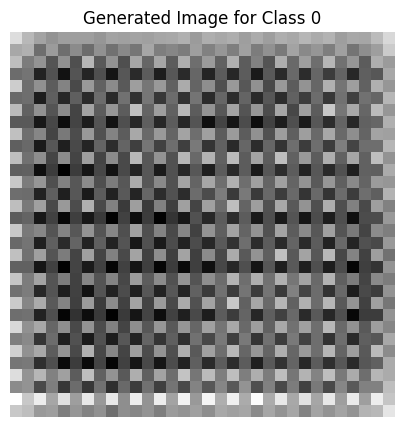

Epoch [1/100], D_loss: -133.37466430664062, G_loss: 105.74514770507812


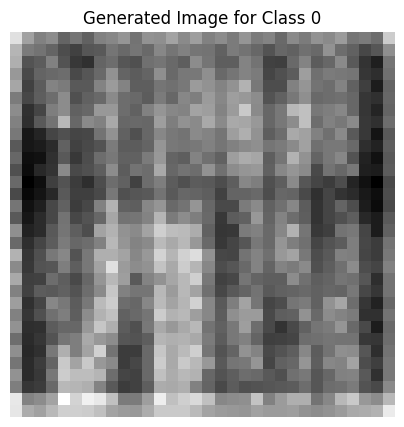

Epoch [2/100], D_loss: -8.438053131103516, G_loss: -3.2238316535949707


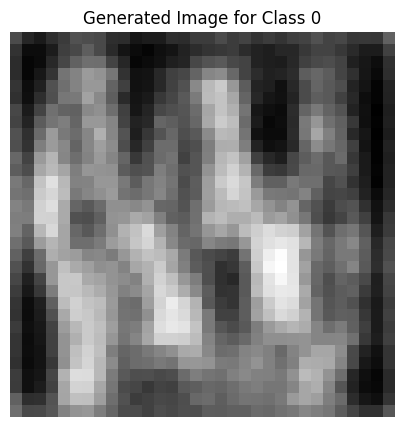

Epoch [3/100], D_loss: -46.736328125, G_loss: 19.887351989746094


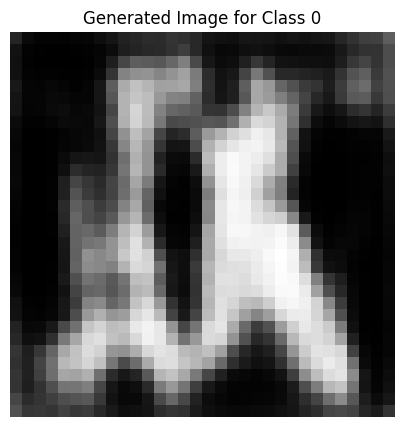

Epoch [4/100], D_loss: -23.736370086669922, G_loss: -11.389066696166992


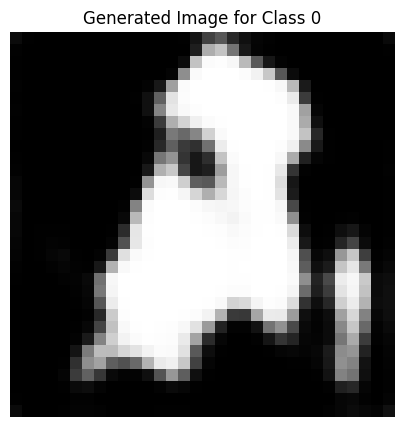

Epoch [5/100], D_loss: -4.343279838562012, G_loss: -15.110466957092285


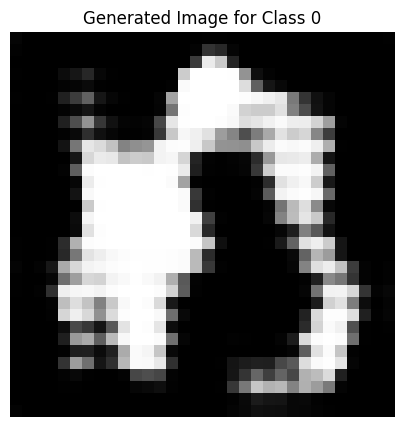

Epoch [6/100], D_loss: -15.498472213745117, G_loss: -0.525855302810669


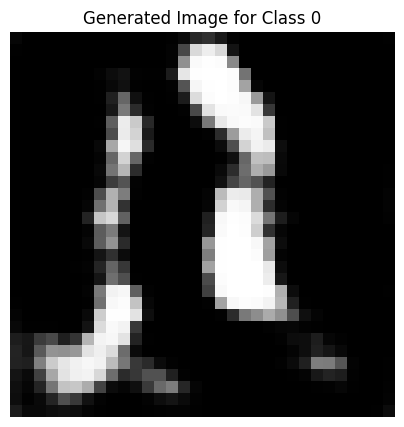

Epoch [7/100], D_loss: -14.25241470336914, G_loss: 1.118486762046814


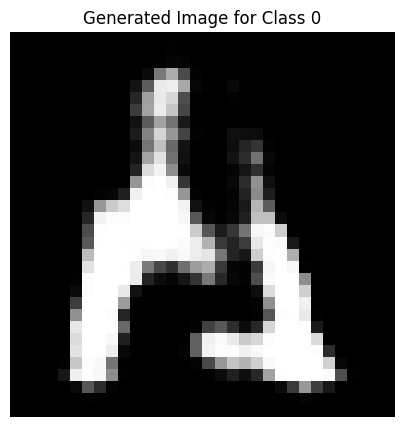

Epoch [8/100], D_loss: -16.32318687438965, G_loss: 5.5027570724487305


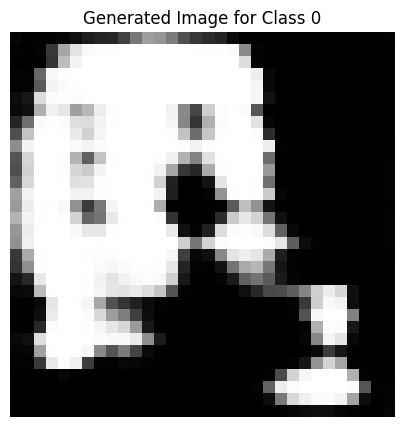

Epoch [9/100], D_loss: -16.73833465576172, G_loss: 8.802937507629395


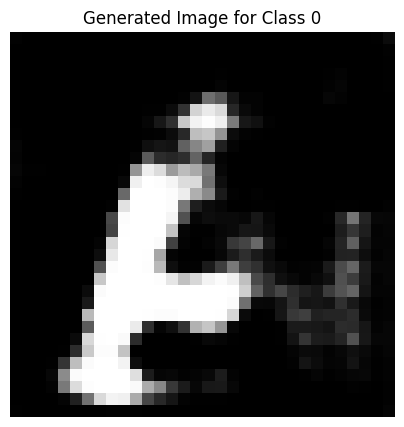

Epoch [10/100], D_loss: -17.068336486816406, G_loss: 9.391666412353516


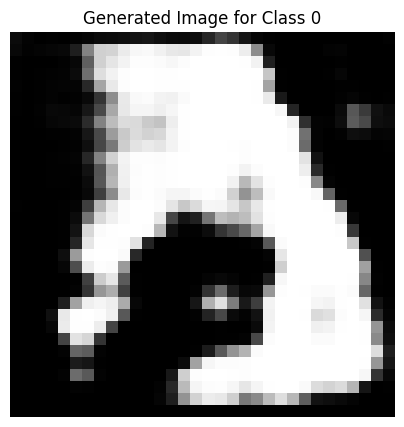

Epoch [11/100], D_loss: -10.956658363342285, G_loss: 6.437149524688721


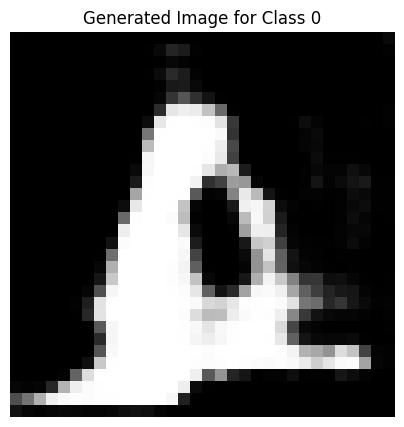

Epoch [12/100], D_loss: -19.672100067138672, G_loss: 12.938993453979492


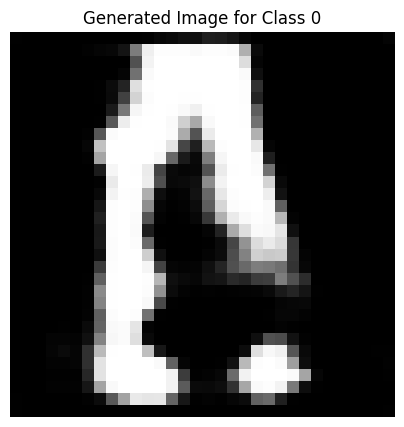

Epoch [13/100], D_loss: -9.75003719329834, G_loss: 14.85215950012207


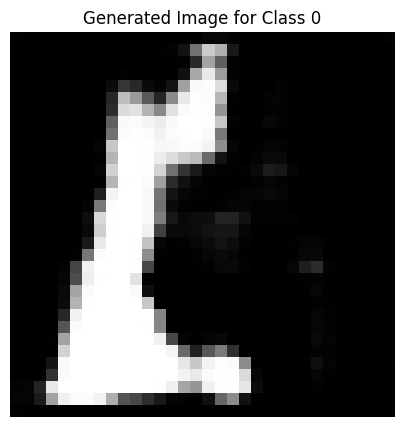

Epoch [14/100], D_loss: -20.203632354736328, G_loss: 15.347024917602539


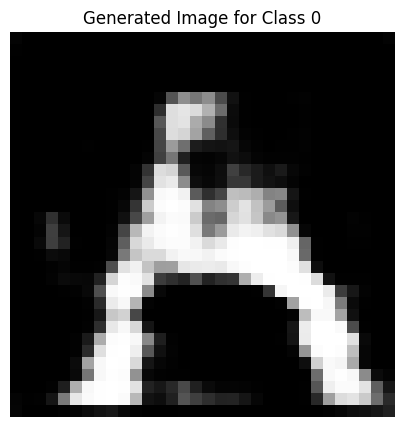

Epoch [15/100], D_loss: -9.15107536315918, G_loss: 9.793684005737305


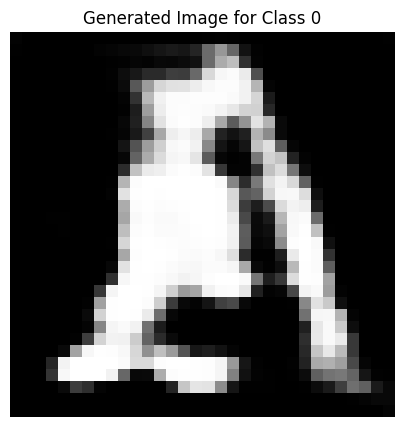

Epoch [16/100], D_loss: -15.116969108581543, G_loss: 13.068475723266602


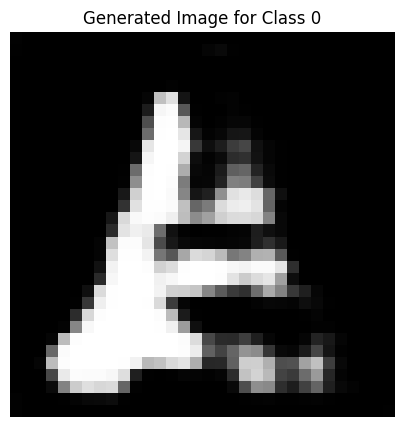

Epoch [17/100], D_loss: -15.243847846984863, G_loss: 16.65816879272461


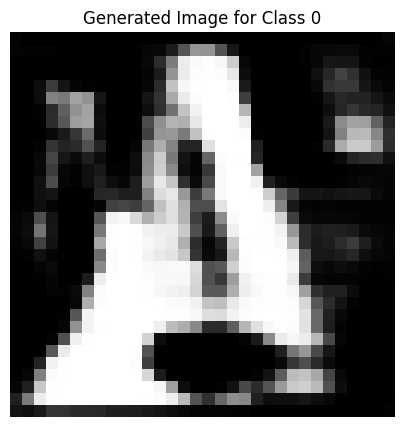

Epoch [18/100], D_loss: -17.512256622314453, G_loss: 12.832498550415039


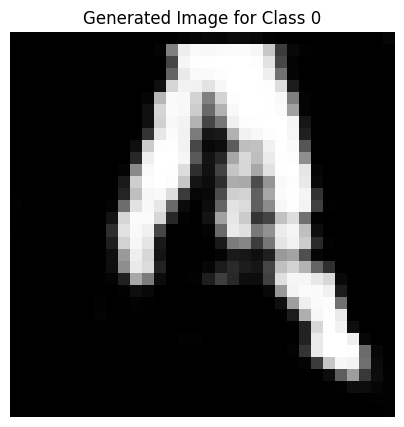

Epoch [19/100], D_loss: -9.531474113464355, G_loss: 16.320354461669922


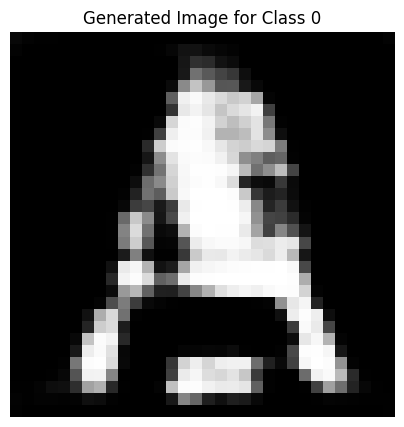

Epoch [20/100], D_loss: -14.301179885864258, G_loss: 16.361637115478516


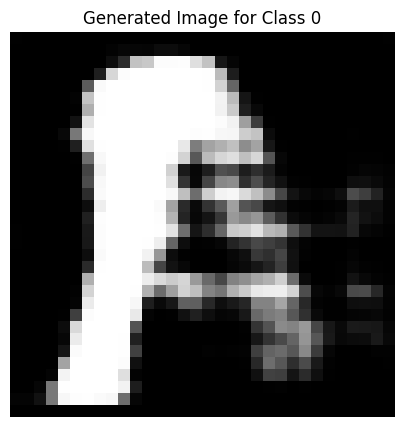

Epoch [21/100], D_loss: -12.987055778503418, G_loss: 21.758100509643555


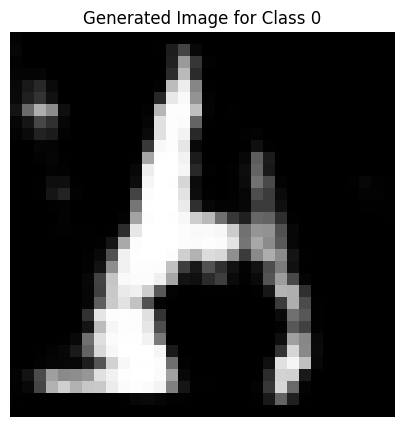

Epoch [22/100], D_loss: -14.880243301391602, G_loss: 15.095871925354004


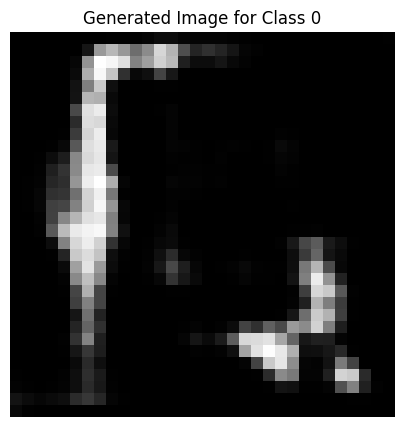

Epoch [23/100], D_loss: -19.547401428222656, G_loss: 16.474788665771484


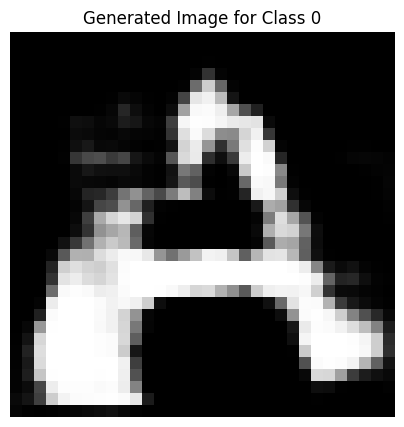

Epoch [24/100], D_loss: 28.996681213378906, G_loss: 13.511093139648438


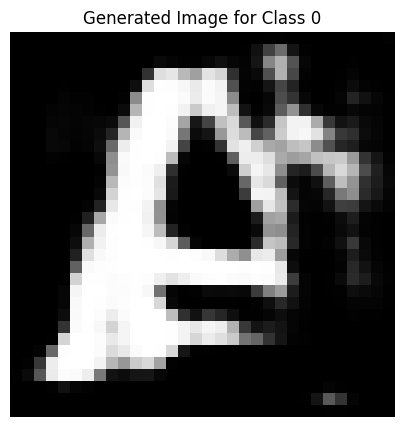

Epoch [25/100], D_loss: -22.314773559570312, G_loss: 17.018390655517578


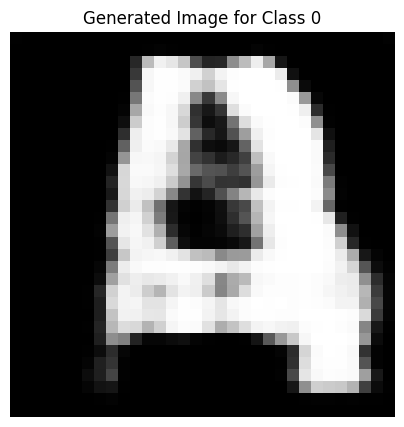

Epoch [26/100], D_loss: -10.920429229736328, G_loss: 21.46834373474121


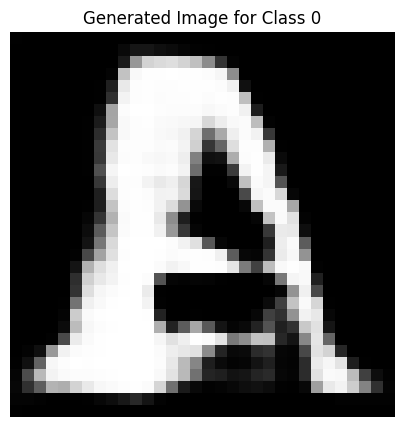

Epoch [27/100], D_loss: -18.067676544189453, G_loss: 19.3419189453125


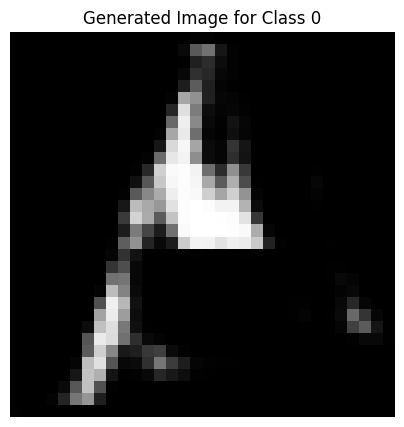

Epoch [28/100], D_loss: -18.976173400878906, G_loss: 20.040081024169922


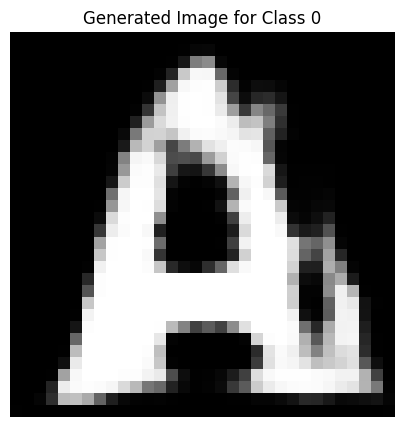

Epoch [29/100], D_loss: -16.526012420654297, G_loss: 23.012630462646484


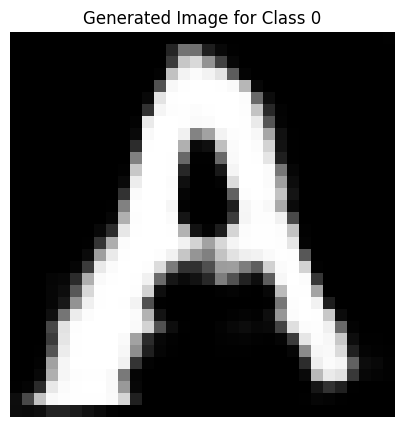

Epoch [30/100], D_loss: -9.454145431518555, G_loss: 23.606792449951172


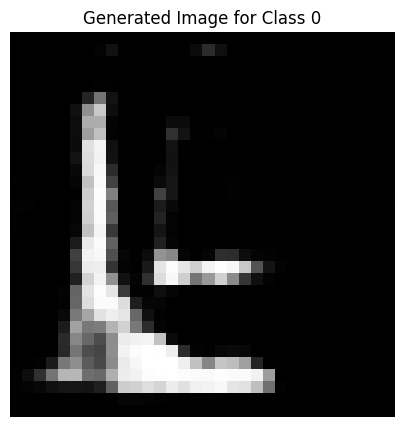

Epoch [31/100], D_loss: -10.211945533752441, G_loss: 22.2722225189209


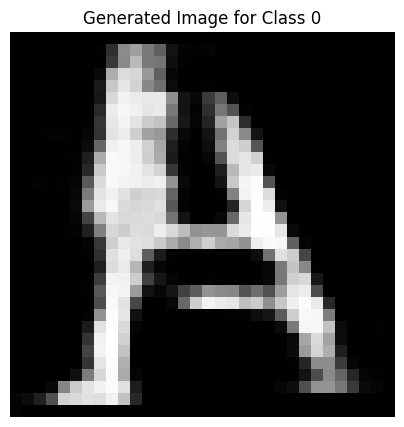

Epoch [32/100], D_loss: -10.900885581970215, G_loss: 29.04413414001465


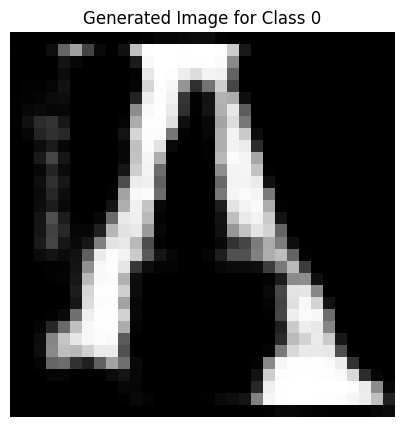

Epoch [33/100], D_loss: 15.033300399780273, G_loss: 20.51921844482422


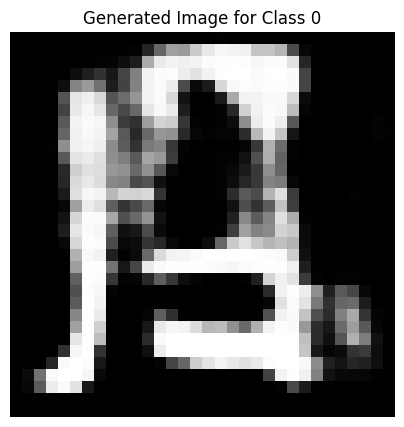

Epoch [34/100], D_loss: -4.421438217163086, G_loss: 39.599388122558594


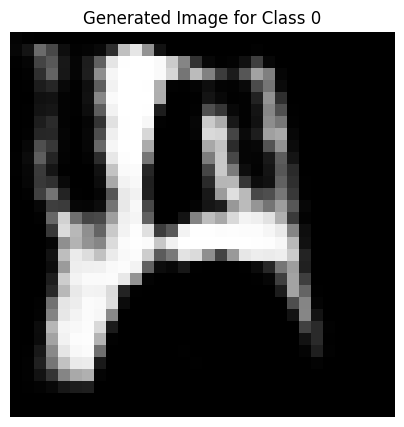

Epoch [35/100], D_loss: -25.123790740966797, G_loss: 24.277053833007812


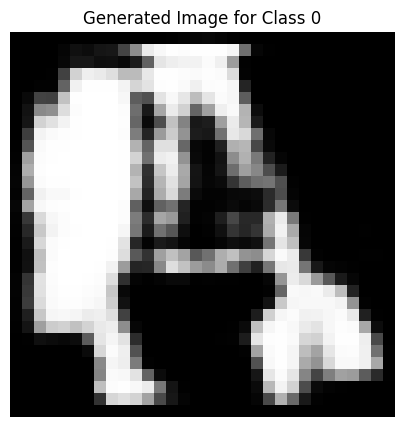

Epoch [36/100], D_loss: -12.839969635009766, G_loss: 28.029470443725586


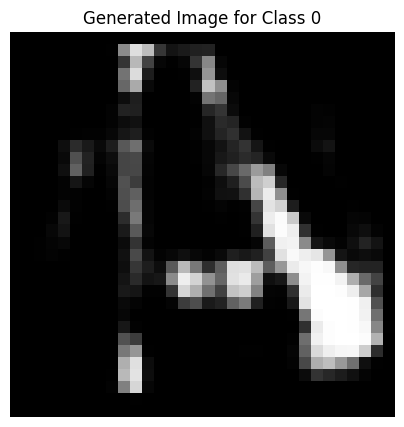

Epoch [37/100], D_loss: -18.948806762695312, G_loss: 34.78813934326172


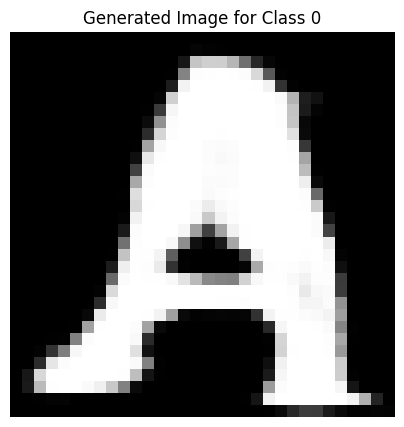

Epoch [38/100], D_loss: -14.425171852111816, G_loss: 35.06447219848633


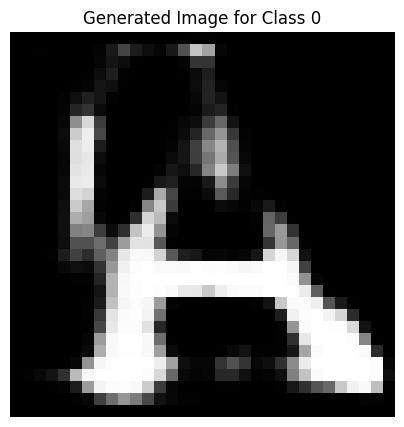

Epoch [39/100], D_loss: -16.335350036621094, G_loss: 36.92988967895508


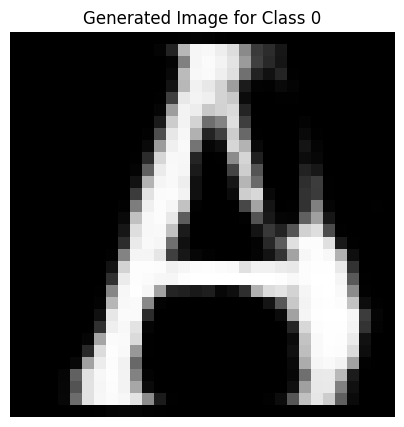

Epoch [40/100], D_loss: 2.9526100158691406, G_loss: 35.382266998291016


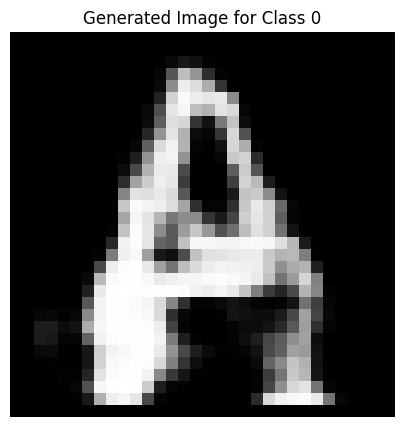

Epoch [41/100], D_loss: -18.008363723754883, G_loss: 31.930788040161133


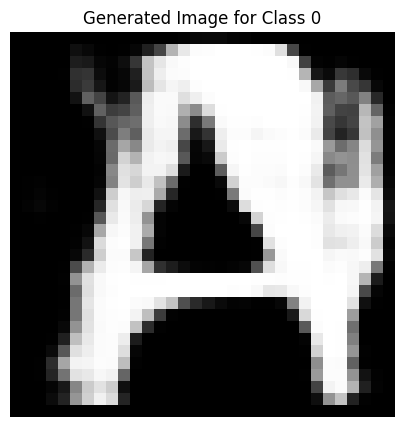

Epoch [42/100], D_loss: -30.08579444885254, G_loss: 44.61412811279297


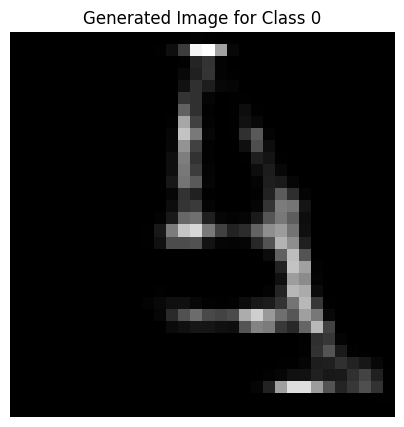

Epoch [43/100], D_loss: -25.11618423461914, G_loss: 39.16166687011719


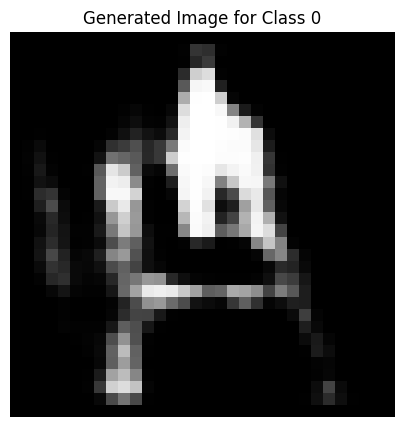

Epoch [44/100], D_loss: -31.457672119140625, G_loss: 33.35700225830078


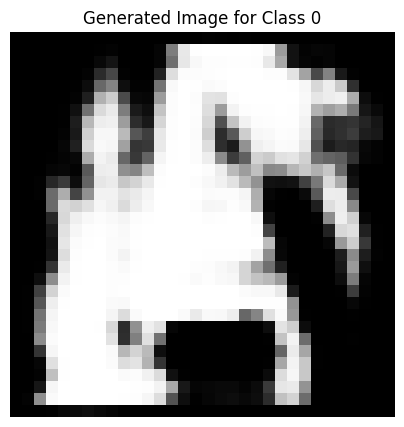

Epoch [45/100], D_loss: -40.36610794067383, G_loss: 38.123191833496094


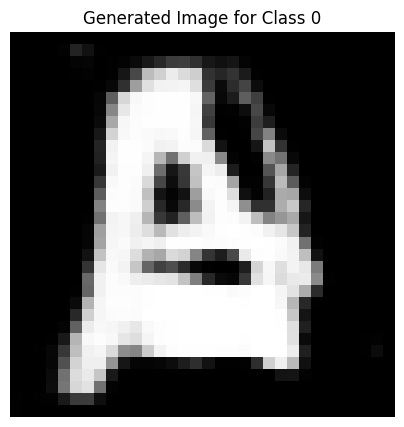

Epoch [46/100], D_loss: -19.956989288330078, G_loss: 29.075714111328125


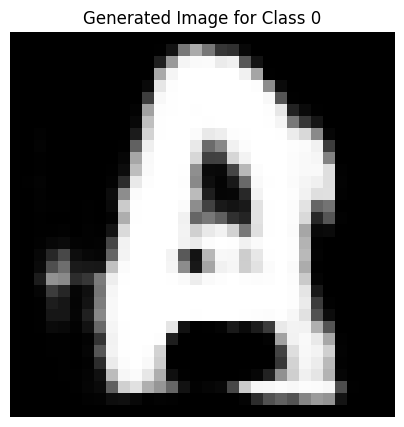

Epoch [47/100], D_loss: -24.952983856201172, G_loss: 39.04734802246094


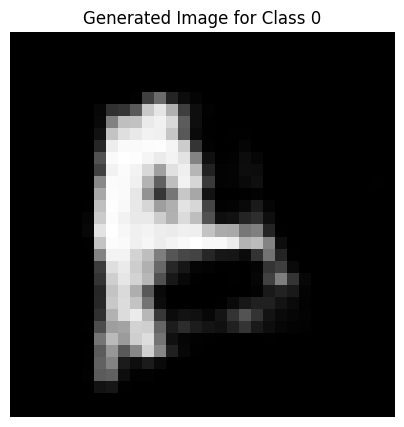

Epoch [48/100], D_loss: -4.100471496582031, G_loss: 24.888439178466797


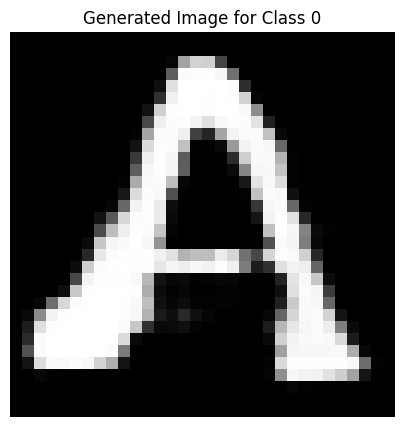

Epoch [49/100], D_loss: -36.391353607177734, G_loss: 38.88325881958008


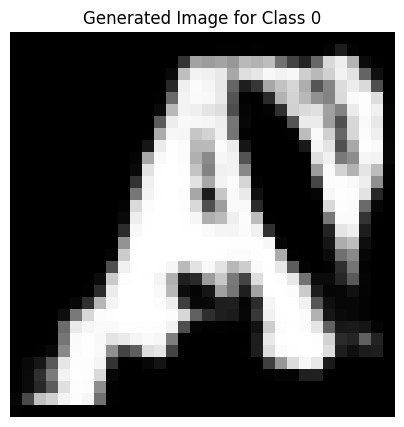

Epoch [50/100], D_loss: -16.931400299072266, G_loss: 35.226043701171875


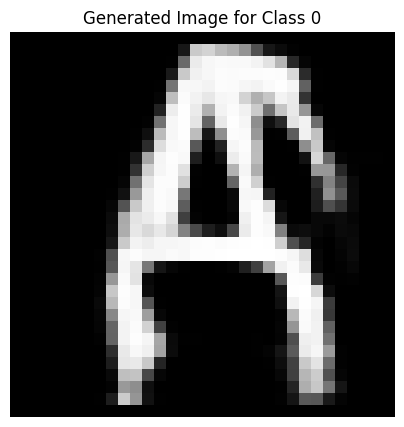

Epoch [51/100], D_loss: -30.917512893676758, G_loss: 42.2917366027832


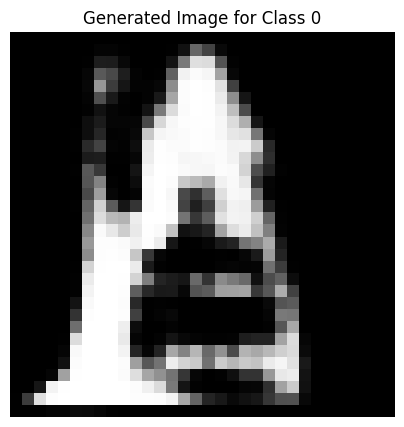

Epoch [52/100], D_loss: -9.22525691986084, G_loss: 42.570350646972656


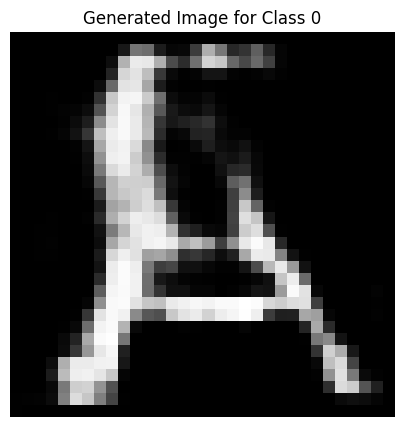

Epoch [53/100], D_loss: -28.03835105895996, G_loss: 45.20301055908203


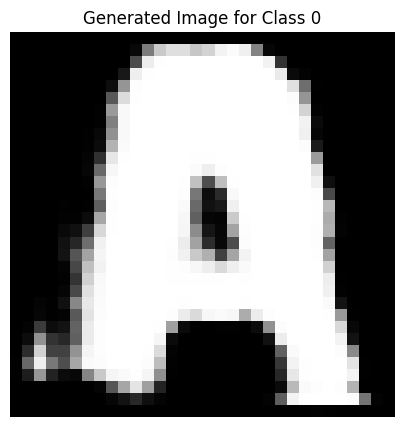

Epoch [54/100], D_loss: -19.26175308227539, G_loss: 39.31135559082031


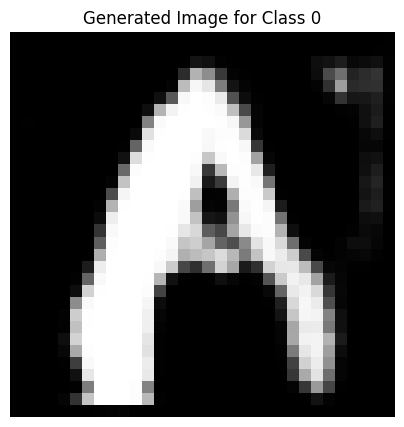

Epoch [55/100], D_loss: -32.994239807128906, G_loss: 50.09046936035156


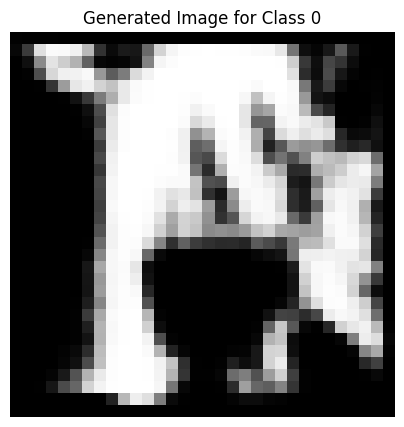

Epoch [56/100], D_loss: -23.584318161010742, G_loss: 50.361209869384766


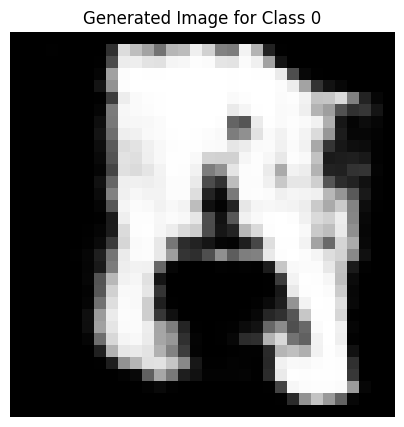

Epoch [57/100], D_loss: -40.675472259521484, G_loss: 53.91958236694336


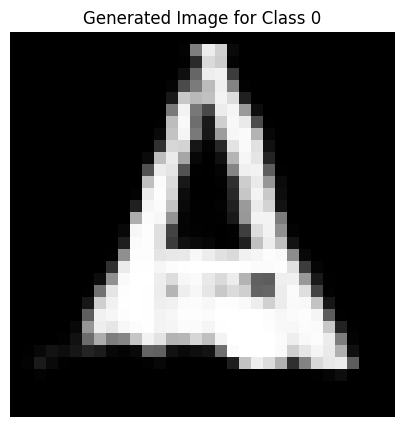

Epoch [58/100], D_loss: -27.340431213378906, G_loss: 39.736854553222656


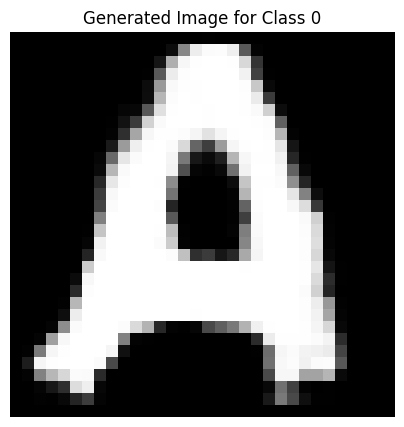

Epoch [59/100], D_loss: 25.88646697998047, G_loss: 31.942148208618164


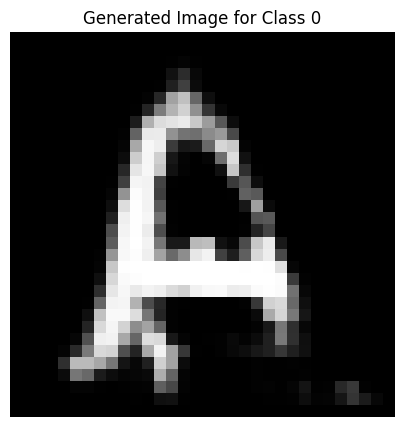

Epoch [60/100], D_loss: -11.014073371887207, G_loss: 50.69611358642578


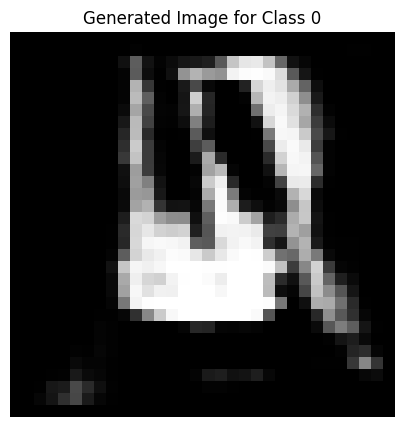

Epoch [61/100], D_loss: -22.075822830200195, G_loss: 39.96136474609375


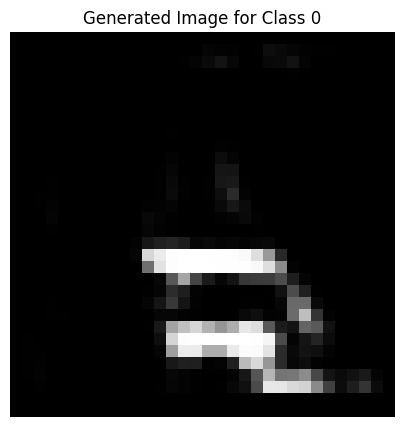

Epoch [62/100], D_loss: -15.866169929504395, G_loss: 40.942047119140625


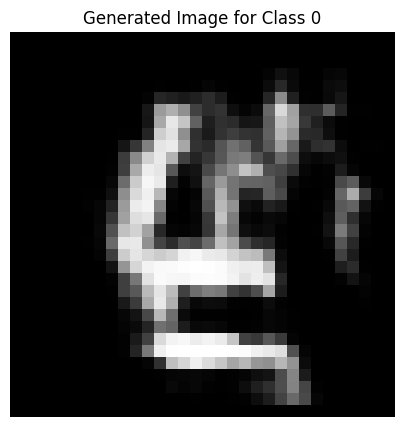

Epoch [63/100], D_loss: 42.54248046875, G_loss: 35.39164352416992


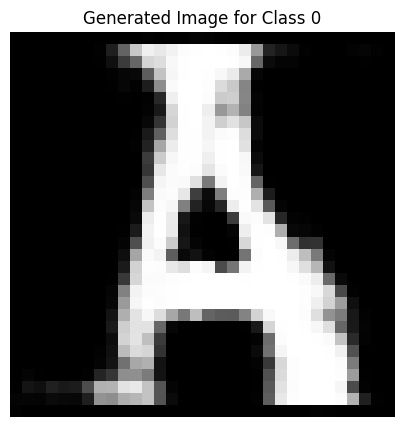

Epoch [64/100], D_loss: -38.5186767578125, G_loss: 45.23386764526367


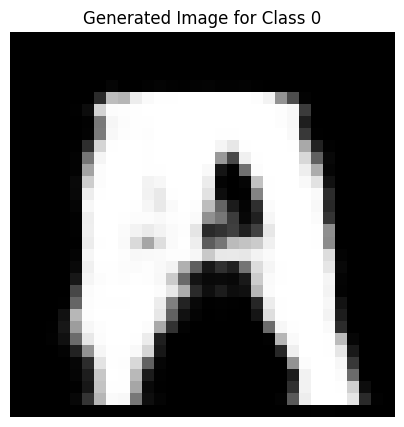

Epoch [65/100], D_loss: -33.36308288574219, G_loss: 56.55083465576172


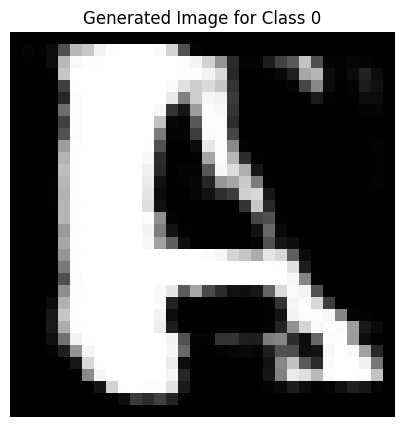

Epoch [66/100], D_loss: -37.33055877685547, G_loss: 52.450927734375


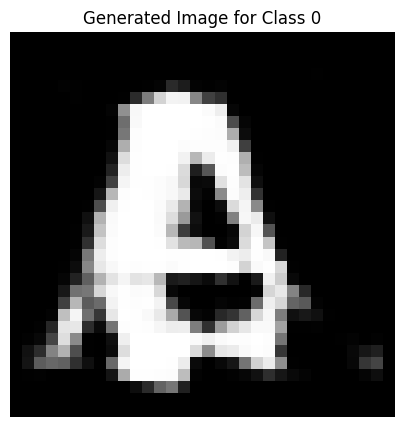

Epoch [67/100], D_loss: -28.765644073486328, G_loss: 46.57880783081055


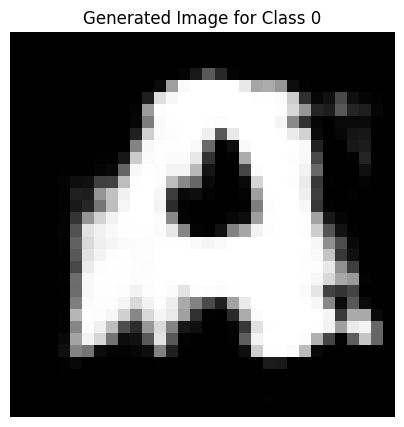

Epoch [68/100], D_loss: 10.259941101074219, G_loss: 53.129493713378906


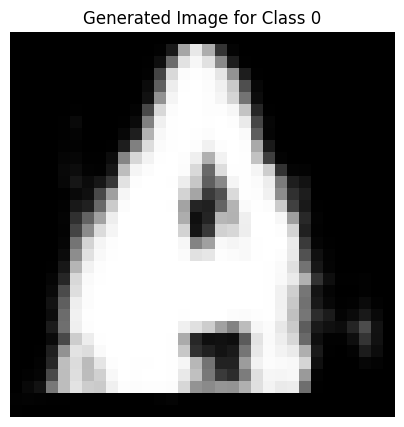

Epoch [69/100], D_loss: -38.60783386230469, G_loss: 50.90372848510742


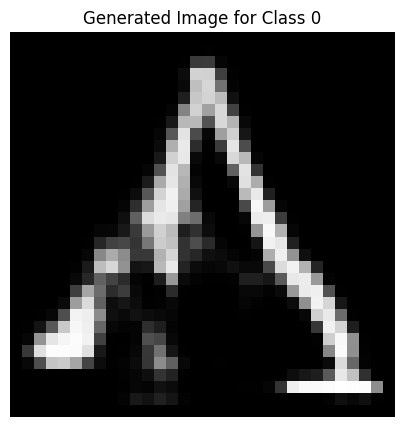

Epoch [70/100], D_loss: -32.5145263671875, G_loss: 38.66265869140625


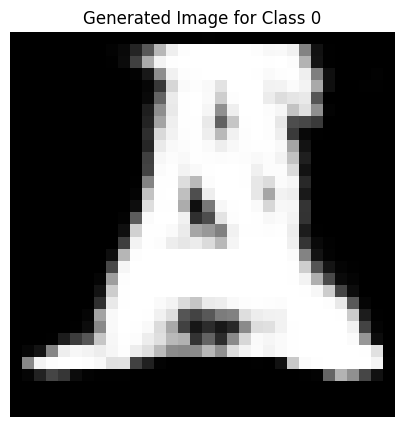

Epoch [71/100], D_loss: -18.59488296508789, G_loss: 60.19618225097656


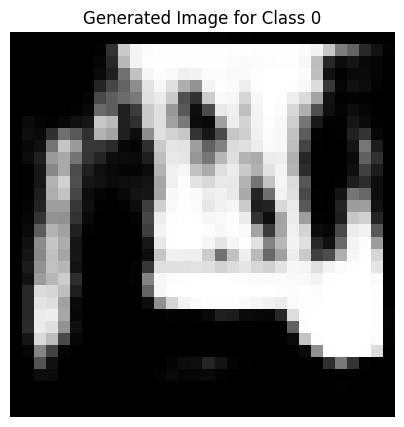

Epoch [72/100], D_loss: -13.1331787109375, G_loss: 45.7818603515625


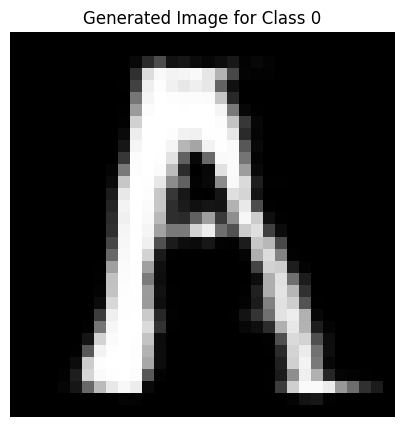

Epoch [73/100], D_loss: -30.767539978027344, G_loss: 57.22104263305664


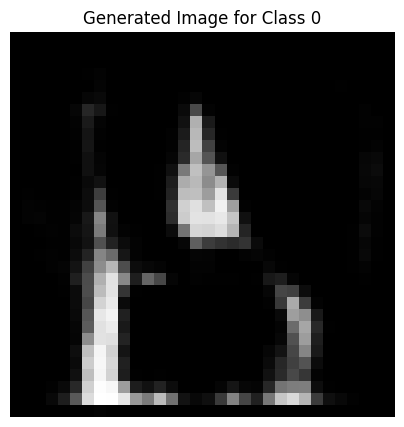

Epoch [74/100], D_loss: -13.522417068481445, G_loss: 64.98640441894531


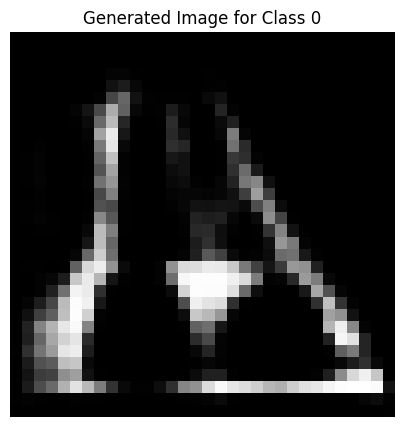

Epoch [75/100], D_loss: -9.406734466552734, G_loss: 63.653160095214844


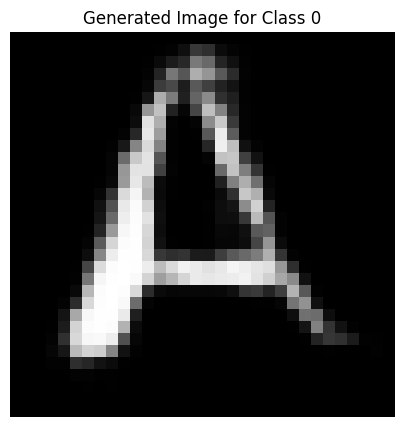

Epoch [76/100], D_loss: -17.834728240966797, G_loss: 55.957786560058594


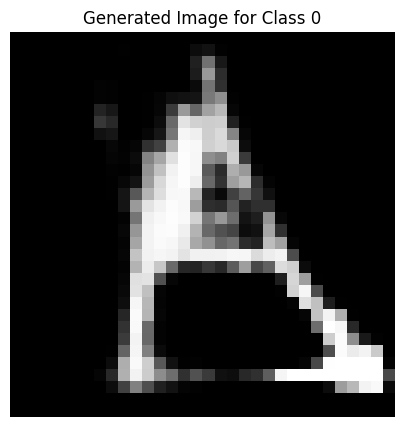

Epoch [77/100], D_loss: 26.798805236816406, G_loss: 57.43771743774414


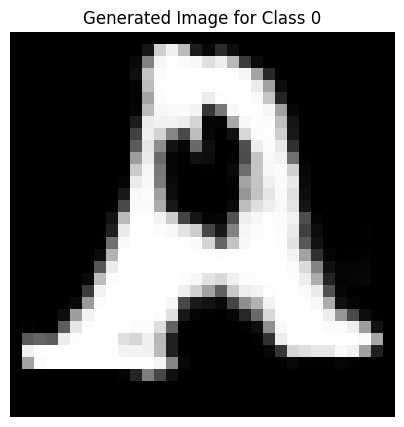

Epoch [78/100], D_loss: -20.022977828979492, G_loss: 64.10881805419922


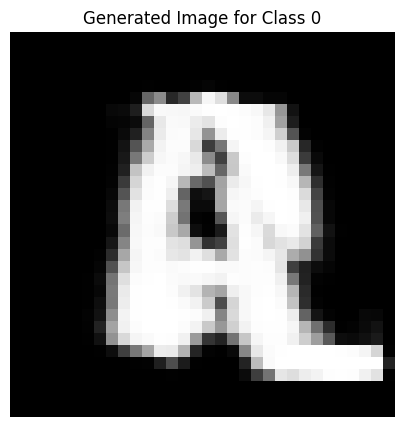

Epoch [79/100], D_loss: -31.803234100341797, G_loss: 58.57429504394531


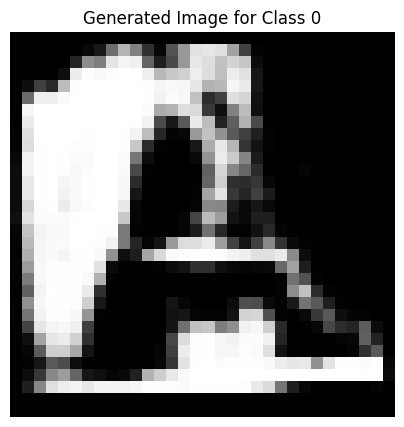

Epoch [80/100], D_loss: -21.11530303955078, G_loss: 62.41636657714844


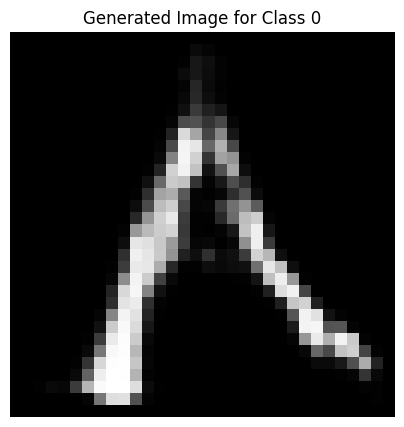

Epoch [81/100], D_loss: -20.270782470703125, G_loss: 65.97080993652344


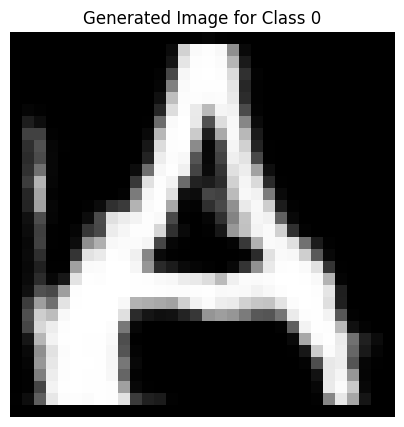

Epoch [82/100], D_loss: -34.80182647705078, G_loss: 65.90618896484375


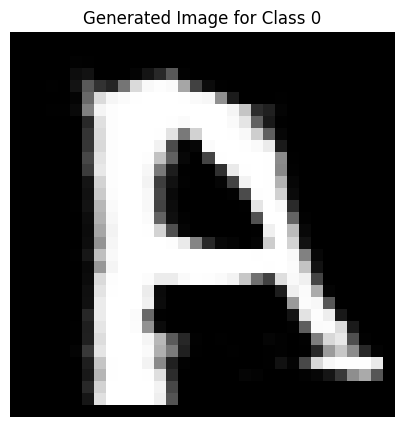

Epoch [83/100], D_loss: -25.303861618041992, G_loss: 54.94031524658203


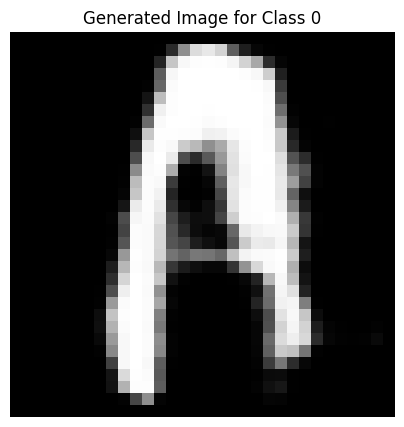

Epoch [84/100], D_loss: -48.26377868652344, G_loss: 66.69029235839844


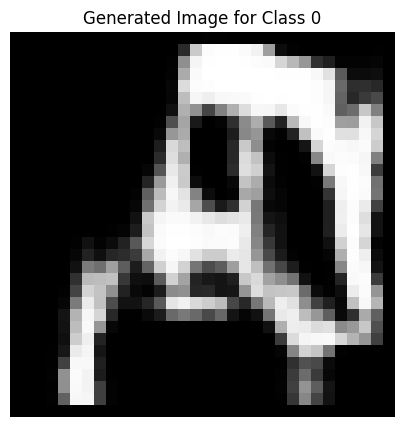

Epoch [85/100], D_loss: -27.96359634399414, G_loss: 56.92432403564453


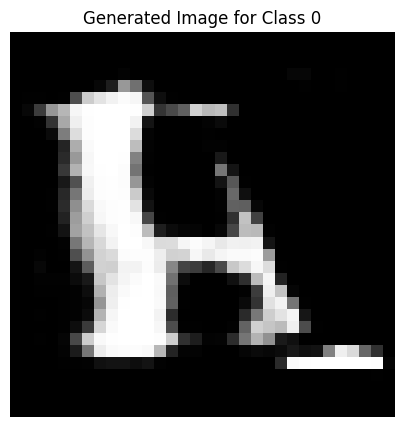

Epoch [86/100], D_loss: -25.950258255004883, G_loss: 78.83308410644531


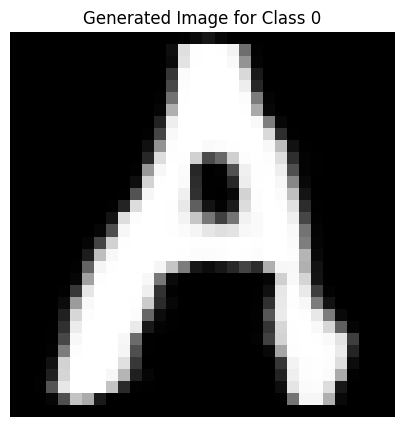

Epoch [87/100], D_loss: -24.561473846435547, G_loss: 56.42280578613281


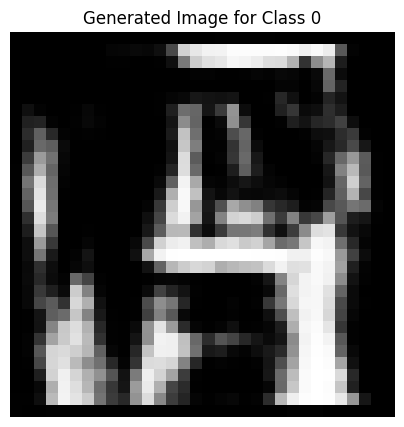

Epoch [88/100], D_loss: -38.749359130859375, G_loss: 62.39788055419922


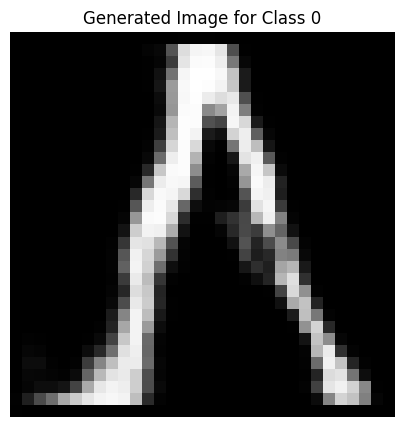

Epoch [89/100], D_loss: -13.932334899902344, G_loss: 64.80714416503906


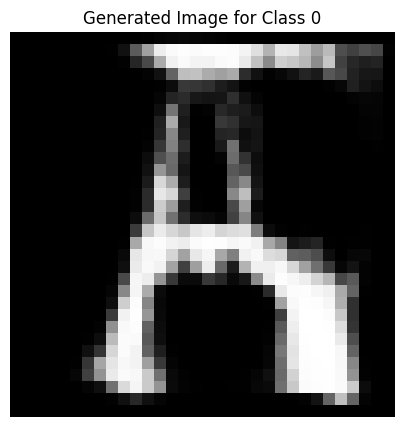

Epoch [90/100], D_loss: -36.123722076416016, G_loss: 73.58470916748047


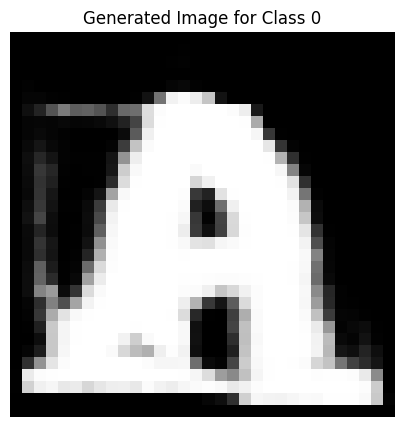

Epoch [91/100], D_loss: -25.720136642456055, G_loss: 76.5703125


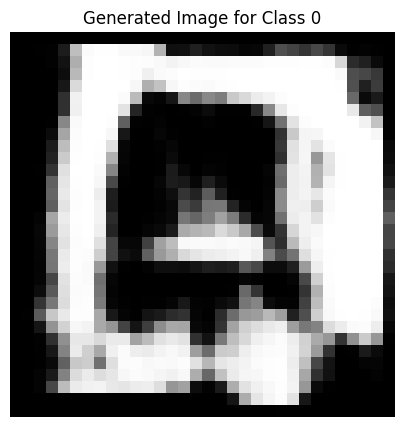

Epoch [92/100], D_loss: 54.05511474609375, G_loss: 78.3980484008789


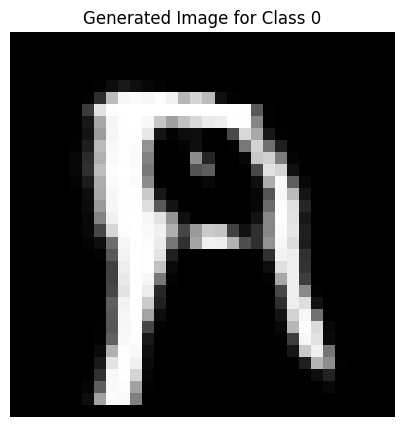

Epoch [93/100], D_loss: -36.060672760009766, G_loss: 74.2940673828125


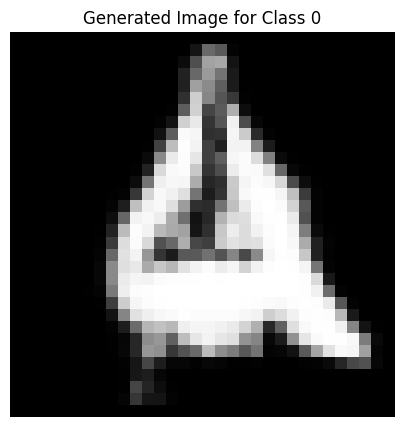

Epoch [94/100], D_loss: -20.236034393310547, G_loss: 67.18765258789062


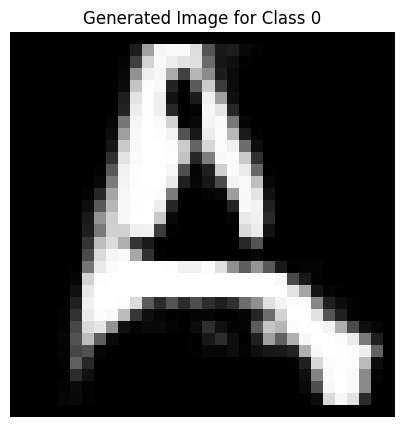

Epoch [95/100], D_loss: -30.876373291015625, G_loss: 70.95436096191406


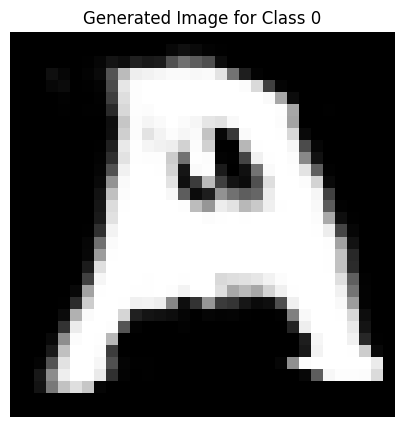

Epoch [96/100], D_loss: -16.353012084960938, G_loss: 63.08356475830078


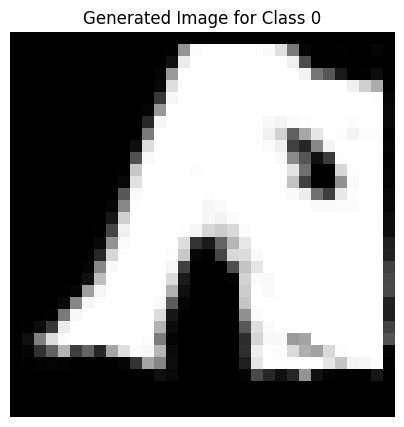

Epoch [97/100], D_loss: -16.582958221435547, G_loss: 83.03433227539062


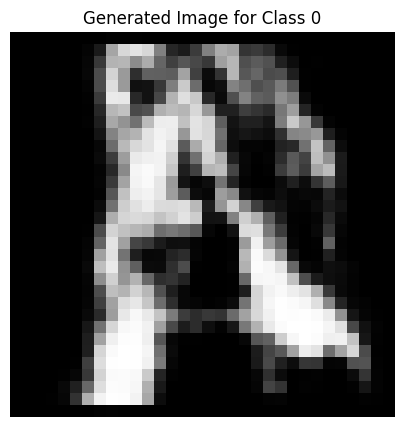

Epoch [98/100], D_loss: -33.01775360107422, G_loss: 74.53648376464844


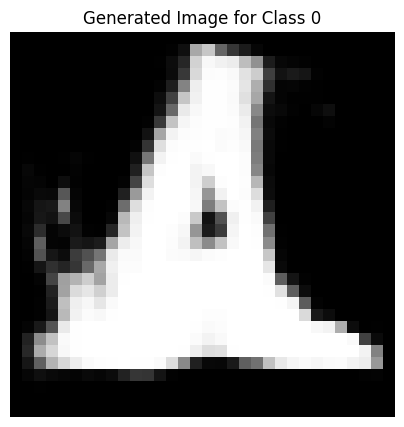

Epoch [99/100], D_loss: -30.720626831054688, G_loss: 80.6298828125


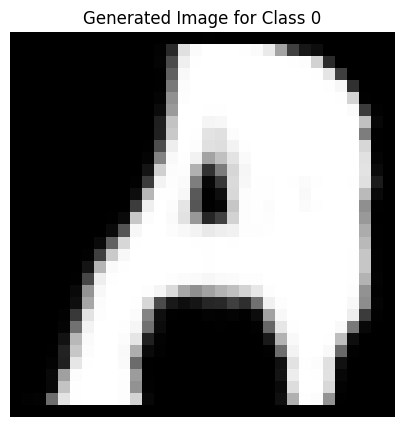

Epoch [100/100], D_loss: -23.482999801635742, G_loss: 73.0011215209961


In [53]:
# Hyperparameters
z_dim = 100
num_classes = 26  # For uppercase alphabets
img_size = 32  # Assuming 32x32 images
batch_size = 64
lr = 0.0002
lambda_gp = 10  # Gradient penalty weight
n_critic = 5  # Number of discriminator updates per generator update
epochs = 100
dataset = NPZDataset(npz_file, transform, 0, 10000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and optimizers
generator = ConvGenerator(z_dim, num_classes, img_size).cuda()
discriminator = ConvDiscriminator(img_size).cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Training
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        # Fix real_imgs shape

        real_imgs = real_imgs.permute(0, 2, 1, 3).cuda()
        labels = labels.cuda()
        batch_size = labels.shape[0]
        # Generate one-hot vectors for labels
        z_c = torch.zeros(batch_size, num_classes).cuda()
        z_c[torch.arange(batch_size), labels] = 1

        # Train Discriminator
        z_s = torch.randn(batch_size, z_dim).cuda()
        z = torch.cat((z_s, z_c), dim=1)  # Shape: (batch_size, z_dim + num_classes)
        fake_imgs = generator(z)
        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs.detach())  # Detach to avoid affecting generator
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator every n_critic steps
        if i % n_critic == 0:
            z_s = torch.randn(batch_size, z_dim).cuda()  # Regenerate z_s
            z = torch.cat((z_s, z_c), dim=1)  # Shape: (batch_size, z_dim + num_classes)
            fake_imgs = generator(z)  # Generate new fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            optimizer_G.zero_grad()
            g_loss.backward()  # No retain_graph needed
            optimizer_G.step()

    displayGeneratedImage(class_index=0, generator=generator, z_dim=z_dim, num_classes=num_classes, device='cuda')
    print(f"Epoch [{epoch+1}/{epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}")